In [105]:
# Import packages.
import cvxpy as cp
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt

In [106]:
'''
Experiment 0:
Normal distribution
'''

'\nExperiment 0:\nNormal distribution\n'

In [107]:
# Set a random seed for reproducibility
np.random.seed(50)

# Define the mean and covariance matrix
mean =  np.arange(0.1, 0.6, 0.1)  # 5-dimensional mean vector 
cov = np.diag(np.arange(1,6))# 5-dimensional identity matrix as covariance (unit variance)
# Generate 100 samples from the multivariate normal distribution
samples = np.random.multivariate_normal(mean, cov, size=1000)

# Calculate the sample mean
sample_mean = np.mean(samples, axis=0)

# Calculate the sample covariance
sample_covariance = np.cov(samples, rowvar=False)  # rowvar=False indicates that columns represent variables

# Print the results
print("Sample Mean:", sample_mean)
print("Sample Covariance Matrix:\n", sample_covariance)

Sample Mean: [0.09280361 0.19153302 0.40777376 0.44874202 0.54128286]
Sample Covariance Matrix:
 [[ 9.82022305e-01  5.07458331e-03 -5.05268465e-02 -5.10077955e-02
  -3.56395935e-03]
 [ 5.07458331e-03  2.06944924e+00  2.40732899e-02 -6.93266892e-04
  -7.21950534e-02]
 [-5.05268465e-02  2.40732899e-02  2.87412783e+00  1.92885751e-02
  -3.81248467e-02]
 [-5.10077955e-02 -6.93266892e-04  1.92885751e-02  4.50295605e+00
  -3.62615094e-02]
 [-3.56395935e-03 -7.21950534e-02 -3.81248467e-02 -3.62615094e-02
   4.72741543e+00]]


In [108]:
# N assets
N = sample_mean.shape[0]
# S sample size
S = 1000
# Sigma
Sig = sample_covariance
# Sigma^{1/2}
Sig2 = np.linalg.cholesky(Sig)
print(np.allclose(Sig, Sig2 @ Sig2.T)) 
# muhat
mu = sample_mean
#confidence level alpha
alpha = 0.05
# standard norm quantile
z_95 = stats.norm.ppf(1-alpha)
z_975 = stats.norm.ppf(1-alpha/2)
# delta^2 = chi^2 quantile
delta2 = stats.chi2.ppf(1-alpha, df=N)
# lambda0
lambda0 = 0.5
# beta
beta = 0.6


True


In [109]:
# Box uncertainty set
A = np.hstack((Sig2, np.zeros((N,1))))
e = np.ones(N+1)
e[-1] = 0

In [110]:
# Initialize results storage
lambda_values = np.arange(0, 1, 0.2)  # lambda0 from 0 to 1 with step 0.2
results_lambda = []
resultsw_lambda = np.zeros((len(lambda_values), N + 1))
for i, lambda0 in enumerate(lambda_values):
    # Box uncertainty set
    c = mu + (1 - 2 * beta) * (z_975 / np.sqrt(S)) * Sig2 @ np.ones((N))
    c = np.append(c, 1)
    c = c / ((1 - lambda0) * z_95)
    e = np.ones(N + 1)
    e[-1] = 0

    # Set random seed
    np.random.seed(0)
    # SOCP
    # min  f^T x
    # s.t. |||Ax +b|| <=c^T x + d
    #      e^T x = 1

    # Objective function coefficient
    f = np.zeros(N + 1)
    f[-1] = 1

    # Define variables x = [w, t]^T
    x = cp.Variable(N + 1)

    # SOC constraints
    soc_constraints = [cp.SOC(c.T @ x, A @ x)]

    # Define and solve the CVXPY problem
    prob = cp.Problem(cp.Minimize(f.T @ x), soc_constraints + [e.T @ x == 1])
    prob.solve()

    # Store the results
    results_lambda.append(prob.value)
    resultsw_lambda[i] = x.value

# Convert results to a NumPy array for easier plotting
results_lambda = np.array(results_lambda)

In [111]:
# Initialize results storage
beta_values = np.arange(0, 1.1, 0.2)  # beta from 0 to 1 with step 0.2
results_beta = []
lambda0 = 0.5
resultsw_beta = np.zeros((len(beta_values), N + 1))
for i, beta in enumerate(beta_values):
    # Box uncertainty set
    c = mu + (1 - 2 * beta) * (z_975 / np.sqrt(S)) * Sig2 @ np.ones((N))
    c = np.append(c, 1)
    c = c / ((1 - lambda0) * z_95)
    e = np.ones(N + 1)
    e[-1] = 0

    # Set random seed
    np.random.seed(0)
    # SOCP
    # min  f^T x
    # s.t. |||Ax +b|| <=c^T x + d
    #      e^T x = 1

    # Objective function coefficient
    f = np.zeros(N + 1)
    f[-1] = 1

    # Define variables x = [w, t]^T
    x = cp.Variable(N + 1)

    # SOC constraints
    soc_constraints = [cp.SOC(c.T @ x, A @ x)]

    # Define and solve the CVXPY problem
    prob = cp.Problem(cp.Minimize(f.T @ x), soc_constraints + [e.T @ x == 1])
    prob.solve()

    # Store the results
    results_beta.append(prob.value)
    resultsw_beta[i] = x.value

# Convert results to a NumPy array for easier plotting
results_beta = np.array(results_beta)

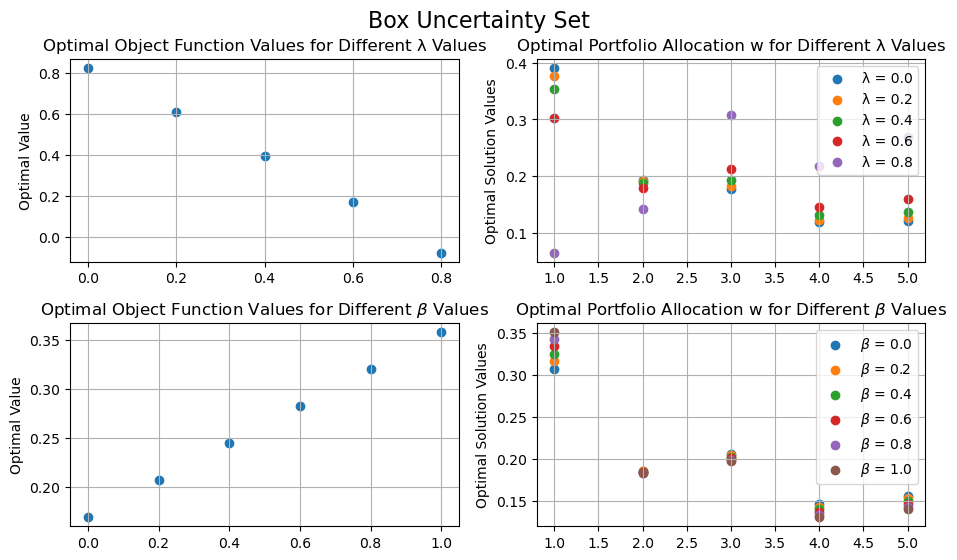

In [112]:
# Create a figure with four subplots
plt.figure(figsize=(9.5, 5.5))

# First subplot
plt.subplot(2, 2, 1)  # 2 rows, 2 columns, 1st subplot
plt.scatter(lambda_values, results_lambda, marker='o')
plt.title('Optimal Object Function Values for Different λ Values')
# plt.xlabel('Lambda')
plt.ylabel('Optimal Value')
plt.xticks(lambda_values)
plt.grid()

# Second subplot
plt.subplot(2, 2, 2)  # 2 rows, 2 columns, 2nd subplot
for i in range(resultsw_lambda.shape[0]):
    plt.scatter(np.arange(1, 6), resultsw_lambda[i, :-1], label=f'λ = {lambda_values[i]:.1f}')
plt.title('Optimal Portfolio Allocation w for Different λ Values')
# plt.xlabel('w')
plt.ylabel('Optimal Solution Values')
plt.legend()
plt.grid()

# Third subplot
plt.subplot(2, 2, 3)  # 3 rows, 2 columns, 5th subplot
plt.subplots_adjust(hspace=0.3)
plt.scatter(beta_values, results_beta, marker='o')
plt.title('Optimal Object Function Values for Different $\\beta$ Values')
# plt.xlabel('$\\beta$')
plt.ylabel('Optimal Value')
plt.xticks(beta_values)
plt.grid()

# Fourth subplot
plt.subplot(2, 2, 4)  # 3 rows, 2 columns, 6th subplot
plt.subplots_adjust(hspace=0.3)
for i in range(resultsw_beta.shape[0]):
    plt.scatter(np.arange(1, 6), resultsw_beta[i, :-1], label=f'$\\beta$ = {beta_values[i]:.1f}')
plt.title('Optimal Portfolio Allocation w for Different $\\beta$ Values')
# plt.xlabel('w')
plt.ylabel('Optimal Solution Values')
plt.legend()
plt.grid()

# Overall title for the figure
plt.suptitle('Box Uncertainty Set', fontsize=16, y=0.99)

# Show the plots
# plt.tight_layout(rect=[0.01, 0.1, 0.93, 0.93])
# plt.tight_layout(rect=[0.01, 0.1, 0.93, 0.93])
plt.subplots_adjust(left=0.07, right=0.97, top=0.9, bottom=0.05)
plt.savefig('box_uncertainty_set.pdf', dpi=800)

In [113]:
# Elliptical set
A1 = np.hstack((Sig2, np.zeros((N,1))))
e1 = np.ones(N+1)
e1[-1] = 0

In [114]:
# Initialize results storage
lambda_values = np.arange(0, 1, 0.2)  # lambda0 from 0 to 1 with step 0.2
results_lambda = []
beta =0.6
resultsw_lambda = np.zeros((len(lambda_values), N + 1))
for i, lambda0 in enumerate(lambda_values):
    # Elliptical uncertainty set
    c1 = np.append(mu, 1)
    a = (1-lambda0)*z_95 + (1-2*beta)*np.sqrt(delta2/S)
    c1 = c1/a
    e = np.ones(N + 1)
    e[-1] = 0

    # Set random seed
    np.random.seed(0)
    # SOCP
    # min  f^T x
    # s.t. |||Ax +b|| <=c^T x + d
    #      e^T x = 1

    # objective function coeficient
    f1 = np.zeros(N + 1) 
    f1[-1] = 1      

    # define variables x=[w,t]^T
    x1 = cp.Variable(N+1)
    # SOC constraints
    soc_constraints1 = [cp.SOC(c1.T @ x1 , A1 @ x1 )]
    # Define and solve the CVXPY problem.
    prob1 = cp.Problem(cp.Minimize(f1.T@x1),
                  soc_constraints1 + [e1.T @ x1 == 1])

    prob1.solve()
# Print result.
    # Store the results
    results_lambda.append(prob1.value)
    resultsw_lambda[i] = x1.value

# Convert results to a NumPy array for easier plotting
results_lambda = np.array(results_lambda)

In [115]:
# Initialize results storage
beta_values = np.arange(0, 1.1, 0.2)  # beta from 0 to 1 with step 0.2
results_beta = []
lambda0 = 0.5
resultsw_beta = np.zeros((len(beta_values), N + 1))
for i, beta in enumerate(beta_values):
    # Elliptical uncertainty set
    c1 = np.append(mu, 1)
    a = (1-lambda0)*z_95 + (1-2*beta)*np.sqrt(delta2/S)
    c1 = c1/a
    e = np.ones(N + 1)
    e[-1] = 0

    # Set random seed
    np.random.seed(0)
    # SOCP
    # min  f^T x
    # s.t. |||Ax +b|| <=c^T x + d
    #      e^T x = 1

    # objective function coeficient
    f1 = np.zeros(N + 1) 
    f1[-1] = 1      

    # define variables x=[w,t]^T
    x1 = cp.Variable(N+1)
    # SOC constraints
    soc_constraints1 = [cp.SOC(c1.T @ x1 , A1 @ x1 )]
    # Define and solve the CVXPY problem.
    prob1 = cp.Problem(cp.Minimize(f1.T@x1),
                  soc_constraints1 + [e1.T @ x1 == 1])

    prob1.solve()
    # Print result.
    # Store the results
    results_beta.append(prob1.value)
    resultsw_beta[i] = x1.value

# Convert results to a NumPy array for easier plotting
results_beta = np.array(results_beta)

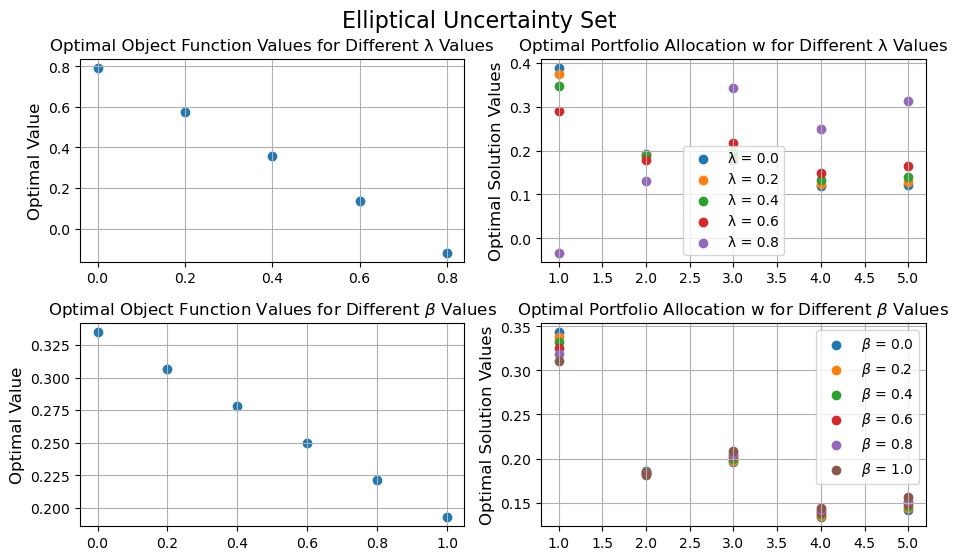

In [119]:
# Create a figure with four subplots
plt.figure(figsize=(9.5, 5.5))

# First subplot
plt.subplot(2, 2, 1)  # 2 rows, 2 columns, 1st subplot
plt.scatter(lambda_values, results_lambda, marker='o')
plt.title('Optimal Object Function Values for Different λ Values', fontsize=12)
# plt.xlabel('Lambda')
plt.ylabel('Optimal Value', fontsize=12)
plt.xticks(lambda_values)
plt.grid()

# Second subplot
plt.subplot(2, 2, 2)  # 2 rows, 2 columns, 2nd subplot
for i in range(resultsw_lambda.shape[0]):
    plt.scatter(np.arange(1, 6), resultsw_lambda[i, :-1], label=f'λ = {lambda_values[i]:.1f}')
plt.title('Optimal Portfolio Allocation w for Different λ Values', fontsize=12)
# plt.xlabel('w')
plt.ylabel('Optimal Solution Values', fontsize=12)
plt.legend()
plt.grid()

# Third subplot
plt.subplot(2, 2, 3)  # 2 rows, 2 columns, 3rd subplot
plt.subplots_adjust(hspace=0.3)  # Adjust the vertical spacing
plt.scatter(beta_values, results_beta, marker='o')
plt.title('Optimal Object Function Values for Different $\\beta$ Values', fontsize=12)
# plt.xlabel('$\\beta$')
plt.ylabel('Optimal Value', fontsize=12)
plt.xticks(beta_values)
plt.grid()

# Fourth subplot
plt.subplot(2, 2, 4)  # 2 rows, 2 columns, 4th subplot
plt.subplots_adjust(hspace=0.3)  # Adjust the vertical spacing
for i in range(resultsw_beta.shape[0]):
    plt.scatter(np.arange(1, 6), resultsw_beta[i, :-1], label=f'$\\beta$ = {beta_values[i]:.1f}')
plt.title('Optimal Portfolio Allocation w for Different $\\beta$ Values', fontsize=12)
# plt.xlabel('w')
plt.ylabel('Optimal Solution Values', fontsize=12)
plt.legend()
plt.grid()

# Overall title for the figure
plt.suptitle('Elliptical Uncertainty Set', fontsize=16, y=0.99)

# Show the plots
# plt.tight_layout(rect=[0, 0.03, 1, 0.95])  # Adjust layout to make room for the title
plt.subplots_adjust(left=0.08, right=0.97, top=0.9, bottom=0.05)
plt.savefig('elliptical_uncertainty_set.pdf', dpi=800)